In [1]:
import sys
import json
import cobra
import cplex
import re
import logging
from configparser import ConfigParser
config = ConfigParser()
config.read("config.cfg")
paths = config.get("script", "syspaths").split(";")
for path in paths:
    sys.path.append(path)
import cobrakbase
from escher import Builder
from optlang.symbolics import Zero, add
from modelseedpy import MSPackageManager, MSExpression,MSCommunity
from sklearn.metrics import r2_score
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
kbase_api = cobrakbase.KBaseAPI()
name = "ModifiedPDV-12-22"
names = ["ExpExchange","SimpThermo","ExpMiscBiomass","EnergyBiomass","CorrectedGrowth","ModifiedPDV-12-22"]

cobrakbase 0.2.8


In [2]:
modelone = kbase_api.get_from_ws("Modified_Athaliana_Model",25427)
modeltwo = kbase_api.get_from_ws("Modified_Athaliana_Model",25427)
commodel = MSCommunity.build_from_species_models([modelone,modeltwo],"AthalianaDayNight","AthalianaDayNight",names=["Day","Night"])
commodel.lp_filename = "merge_test"
solution = commodel.run(None)
solution

,fluxes,reduced_costs
rxn00001_c1,0.000000,0.000000
rxn00001_d1,18.566131,-2.000000
rxn00001_g1,0.000000,-2.000000
rxn00001_v1,0.000000,-2.000000
rxn00001_w1,0.000000,-2.000000
...,...,...
SK_cpd11416_c2,0.000000,3309.685291
bio1,34.397425,-2.000000
SK_cpd11416_c0,34.397425,-2.000000
DM_cpd02701_m1,0.001720,-2.000000


In [1]:
#Uncomment the tissue datastructure for the model you want to run
#Single tissue model:
tissues = ["Mature_leaf"]
#Two tissue model:
#tissues = ["Mature_leaf","GermEmbryo_2_DAI"]
#16 tissue model:
#tissues = ["Mature_leaf","Zone_1","Zone_2","Zone_3","GermEmbryo_2_DAI","Pericarp_Aleurone_27_DAP","Endosperm_Crown_27_DAP","Endosperm_12_DAP","Endosperm_10_DAP","Endosperm_8_DAP","Embryo_38_DAP","Embryo_20_DAP","root_Stele","root_Cortex","root_EZ","root_MZ"]
model = kbase_api.get_from_ws("Modified_Athaliana_Model",25427)
#model =cobra.io.read_sbml_model("Modified_Athaliana_Modelv3.xml")
model.solver = 'optlang-cplex'
#Setting model to complete media
#media = kbase_api.get_from_ws("Carbon-D-Glucose","KBaseMedia")
pkgmgr = MSPackageManager.get_pkg_mgr(model,1)
pkgmgr.getpkg("KBaseMediaPkg",1).build_package(None, default_uptake=1000, default_excretion=1000)
#pkgmgr.getpkg("SimpleThermoPkg",1).build_package({})
#Reading reaction protein abundances
proteome = None
#genome = kbase_api.get_from_ws("Zmays_Ensembl-18_2010-01-MaizeSequence",16026)
proteome = MSExpression.from_gene_feature_file("ProteomeRawData.tsv",None,False)

#Reading reaction kcat values
data = ""
with open('KCats_grouped.txt', 'r') as file:
    data = file.read()
lines = data.split("\n")
reaction_kcat = {}
headers = None
for line in lines:
    if headers == None:
        headers = line.split("\t")
    else:
        array = line.split("\t")
        reaction_kcat[array[0]] = abs(float(array[1]))

#Reading measured reaction fluxes
data = ""
with open('Claudia_dv_Atha_12-22.txt', 'r') as file:
    data = file.read()
lines = data.split("\n")
reaction_measures = {}
headers = None
for line in lines:
    if headers == None:
        headers = line.split("\t")
    else:
        array = line.split("\t")
        if array[1] not in reaction_measures:
                reaction_measures[array[1]] = dict()
        rxnid = array[0]
        reaction_measures[array[1]][rxnid] = abs(float(array[2]))

biomass_fluxes = {
    "root_MZ" : 0.049925,
    "root_EZ" : 0.049925,
    "root_Cortex" : 0.049925,
    "root_Stele" : 0.049925,
    "Embryo_20_DAP" : 0.015591667,
    "Embryo_38_DAP" : 0.015591667,
    "Endosperm_8_DAP" : 0.010208333,
    "Endosperm_10_DAP" : 0.010208333,
    "Endosperm_12_DAP" : 0.010208333,
    "Endosperm_Crown_27_DAP" : 0.010208333,
    "Pericarp_Aleurone_27_DAP" : 0.001529167,
    "GermEmbryo_2_DAI" : 0.015591667,
    "Zone_1" : 0.006395833,
    "Zone_2" : 0.006395833,
    "Zone_3" : 0.006395833,
    "Mature_leaf" : 0.0041667
}

protein_fraction = {
	'root_MZ': 0.05,
	'root_EZ' :0.05,
	'root_Cortex': 0.05,
	'root_Stele' : 0.05,
	'Embryo_20_DAP' : 0.116,
	'Embryo_38_DAP' : 0.116,
	'Endosperm_8_DAP' : 0.08,
	'Endosperm_10_DAP' : 0.08,
	'Endosperm_12_DAP' : 0.08,
	'Endosperm_Crown_27_DAP' : 0.08,
	'Pericarp_Aleurone_27_DAP' : 0.09,
	'GermEmbryo_2_DAI' : 0.116,
	'Zone_1': 0.0948,
	'Zone_2': 0.0948,
	'Zone_3': 0.0948,
	'Mature_leaf': 0.119
}

modellist = []
count = 0
base_model = None
for tissue in tissues:
    print("Tissue:"+tissue)
    #Safe cloning method
    clone_model = cobra.io.json.from_json(cobra.io.json.to_json(model))
    #Applying flexible biomass constraints
    pkgmgr = MSPackageManager.get_pkg_mgr(clone_model,1)
    protein = protein_fraction[tissue]
    protein_flux = -1*(0.2-protein)
    pkgmgr.getpkg("FlexibleBiomassPkg",1).build_package({"bio_rxn_id":"bio1","use_rna_class":[-0.99999,0.99999],
        "use_dna_class":[-0.75,0.75],
        "use_protein_class":[protein_flux,protein_flux],
        "use_energy_class":[-0.5,0.5]})
    pkgmgr.getpkg("FluxFittingPkg",1).build_package({
        "target_flux":reaction_measures[tissue],
        "totalflux":1,
        "set_objective":0,
        "default_rescaling":0.1,
        "rescale_vfit_by_flux":False
    })
    if proteome != None:
        #Adding tissue specific proteome constraints
        package_params = {
            "proteome":proteome,
            "condition":tissue,
            "flux_values":reaction_measures[tissue],
            "prot_coef" : protein_fraction[tissue],#Set to the fraction of the cell that is protein
            "totalflux" : 1,#Set to one if we're fitting flux magnitude rather than actual flux to flux measurements
            "kcat_coef" : 0.02,#kapp = kcat_coef * kcat
            "set_objective":0
        }
        #Only base model fits kcat values
        if count == 0:
            package_params["kcat_values"] = reaction_kcat
        pkgmgr.getpkg("ProteomeFittingPkg",1).build_package(package_params)
    #Constraining biomass flux to reference value
    rxn = clone_model.reactions.get_by_id("bio1")
    rxn.upper_bound = biomass_fluxes[tissue]
    rxn.lower_bound = biomass_fluxes[tissue]
    if count == 0:
        base_model = clone_model
    else:
        modellist.append(clone_model)
    count += 1

#Coefficient for kcat fitting:
kcat_fit = 1e-1
#Coefficient for flux fitting:
flux_fit = 1
#Coefficient for kinetic fitting:
kinetic_fit = 1e-6
#Pulling based model package manager
pkgmgr = MSPackageManager.get_pkg_mgr(base_model,1)
#Merging all models together
if count > 1:
    pkgmgr.getpkg("ProblemReplicationPkg",1).build_package({"models":modellist,"shared_variable_packages":{pkgmgr.getpkg("ProteomeFittingPkg"):["kapp"]}})
#Creating combined objective function
objvars = []
#Adding base model kfit,kvfit,and vfit to objective
for rxnid in pkgmgr.getpkg("FluxFittingPkg").variables["vfit"]:
    objvars.append(flux_fit * pkgmgr.getpkg("FluxFittingPkg").variables["vfit"][rxnid] ** 2)
types = ["vfit"]
if proteome != None:
    types = ["vfit","kfit","kapp","kvfit"]
    for rxnid in pkgmgr.getpkg("ProteomeFittingPkg").variables["kvfit"]: 
        objvars.append(kinetic_fit * pkgmgr.getpkg("ProteomeFittingPkg").variables["kvfit"][rxnid] ** 2)
    for rxnid in pkgmgr.getpkg("ProteomeFittingPkg").variables["kfit"]: 
        objvars.append(kcat_fit * pkgmgr.getpkg("ProteomeFittingPkg").variables["kfit"][rxnid] ** 2)
#Adding sub model kvfit,and vfit to objective
count = 0
for submodel in modellist:
    submgr = MSPackageManager.get_pkg_mgr(submodel)
    for rxnid in submgr.getpkg("FluxFittingPkg").variables["vfit"]:
        varname = submgr.getpkg("FluxFittingPkg").variables["vfit"][rxnid].name
        objvars.append(flux_fit * pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count)][varname] ** 2)
    if proteome != None:
        for rxnid in submgr.getpkg("ProteomeFittingPkg").variables["kvfit"]:
            varname = submgr.getpkg("ProteomeFittingPkg").variables["kvfit"][rxnid].name
            objvars.append(kinetic_fit * pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count)][varname] ** 2)
    count += 1
#Setting the objective
base_model.objective = base_model.problem.Objective(add(objvars), direction="min", sloppy=True)
base_model.optimize()

#Printing LP file
with open('ProteomeDrivenModeling.lp', 'w') as out:
    out.write(str(base_model.solver))

#Pulling solution data
solution_data = {"Name":{}}
count = 0
submodel = None
submgr = None
type_packages = {"vfit":"FluxFittingPkg","kfit":"ProteomeFittingPkg","kapp":"ProteomeFittingPkg","kvfit":"ProteomeFittingPkg"}
for tissue in tissues:
    if count > 0:
        submodel = modellist[count-1]
        submgr = MSPackageManager.get_pkg_mgr(submodel)
    for reaction in base_model.reactions:
        if reaction.id not in solution_data["Name"]:
            solution_data["Name"][reaction.id] = reaction.name
        if tissue+"_flux" not in solution_data:
            solution_data[tissue+"_flux"] = {}
        if count == 0:
            solution_data[tissue+"_flux"][reaction.id] = reaction.flux
        else:
            solution_data[tissue+"_flux"][reaction.id] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.forward_variable.name].primal
            solution_data[tissue+"_flux"][reaction.id] += -1*pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][reaction.reverse_variable.name].primal
    for vartype in types:
        package = type_packages[vartype]            
        for rxnid in pkgmgr.getpkg(package).variables[vartype]:
            if tissue+"_"+vartype not in solution_data:
                solution_data[tissue+"_"+vartype] = {}
            if count == 0:
                solution_data[tissue+"_"+vartype][rxnid] = pkgmgr.getpkg(package).variables[vartype][rxnid].primal
            else:
                varname = submgr.getpkg(package).variables[vartype][rxnid].name
                solution_data[tissue+"_"+vartype][rxnid] = pkgmgr.getpkg("ProblemReplicationPkg").variables[str(count-1)][varname].primal        
    count += 1

SyntaxError: invalid syntax (<ipython-input-1-8582832c43ee>, line 3)

0.8304930392598024


,Name,Mature_leaf_flux,Mature_leaf_vfit
rxn00001_c0,diphosphate phosphohydrolase,17.467413,NaN
rxn00001_d0,diphosphate phosphohydrolase,0.000000,NaN
rxn00001_g0,diphosphate phosphohydrolase,0.000000,NaN
rxn00001_v0,diphosphate phosphohydrolase,0.000000,NaN
rxn00001_w0,diphosphate phosphohydrolase,0.000000,NaN
...,...,...,...
rna_flex,rna_flex,0.004167,NaN
dna_flex,dna_flex,0.003125,NaN
protein_flex,protein_flex,-0.000338,NaN
energy_flex,energy_flex,0.000000,NaN


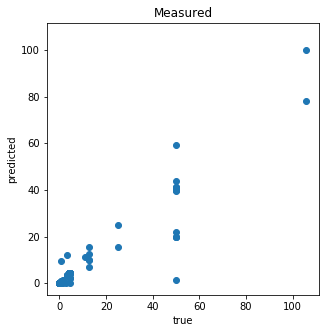

In [3]:
######## r2 measured
tissue="Mature_leaf"
y_pred=[]
y_true=[]
for rxn in reaction_measures[tissue].keys():
    if rxn in model.reactions:
        #if reaction_measures[tissue][rxn]<0.02:
        y_true.append(reaction_measures[tissue][rxn])
        y_pred.append(abs(solution_data[tissue+'_flux'][rxn]))
r2_m=r2_score(y_true,y_pred)
print(r2_m)

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred)
plt.axis('square');
# plt.xlim(-.001,0.04)
# plt.ylim(-0.001,0.04)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("Measured")

solution_data[tissue+"_flux"]["R2"] = r2_m
sol_df=pd.DataFrame.from_dict(solution_data)
sol_df.to_csv(name+".csv", header=True)
sol_df

In [6]:
#Reading measured reaction fluxes
data = ""
with open('Claudia_dv_Atha_v6.1.txt', 'r') as file:
    data = file.read()
lines = data.split("\n")
rxn_meas = {"PDV":{}}
headers = None
for line in lines:
    if headers == None:
        headers = line.split("\t")
    else:
        array = line.split("\t")
        if array[1] not in reaction_measures:
                reaction_measures[array[1]] = dict()
        rxnid = array[0]
        rxn_meas["PDV"][rxnid] = abs(float(array[2]))
df=pd.DataFrame.from_dict(rxn_meas)
df2=df["PDV"]
combined = pd.read_csv("Original.csv",index_col=0)
combined.rename(columns={"Mature_leaf_flux": "Original"}, inplace=True)
combined.drop(columns=["Mature_leaf_vfit"], inplace=True)
combined=combined.merge(df2,how="left",left_index=True,right_index=True)
for name in names:
    df = pd.read_csv(name+".csv",index_col=0)
    df.rename(columns={"Mature_leaf_flux": name}, inplace=True)
    df2=df[name]
    combined=combined.merge(df2, left_index=True, right_index=True)
sort_column = []
is_NaN = combined.isnull()
rowcount = 0
for index, row in combined.iterrows():
    if index == "R2":
        sort_column.append(1100)
    elif "PDV" in row and not is_NaN.iloc[rowcount,2]:
        sort_column.append(1000)
    elif re.search('FLEX_', index) != None:
        total = abs(row["Original"])
        for name in names:
            total += abs(row[name])
        if total > 0:
            sort_column.append(900)
        else:
            sort_column.append(100)
    elif re.search('_flex', index) != None:
        total = abs(row["Original"])
        for name in names:
            total += abs(row[name])
        if total > 0:
            sort_column.append(950)
        else:
            sort_column.append(150)
    elif re.search('EX_', index) != None:
        total = abs(row["Original"])
        for name in names:
            total += abs(row[name])
        if total > 0:
            sort_column.append(800)
        else:
            sort_column.append(50)
    else:
        total = abs(row["Original"])
        for name in names:
            total += abs(row[name])
        if total > 0:
            sort_column.append(700)
        else:
            sort_column.append(25)
    rowcount += 1
combined.insert(0, "Sort", sort_column, True)
combined.sort_values("Sort",ascending=False,inplace=True)
combined.to_csv("Combined.csv", header=True)
combined

,Sort,Name,Original,PDV,ExpExchange,SimpThermo,ExpMiscBiomass,EnergyBiomass,CorrectedGrowth,ModifiedPDV-12-22
R2,1100,NaN,0.782443,NaN,0.810934,0.813842,0.813966,0.828583,0.824561,0.830493
rxn00838_d0,1000,IMP:L-aspartate ligase (GDP-forming),0.002917,0.002917,0.002917,0.002917,0.002917,0.002917,0.002917,0.002917
rxn00777_d0,1000,D-ribose-5-phosphate aldose-ketose-isomerase,15.078760,50.000000,19.746037,19.746037,19.746009,19.746009,19.746633,19.746633
rxn00781_c0,1000,D-glyceraldehyde-3-phosphate:NAD+ oxidoreducta...,-11.247041,4.400000,-4.400000,-4.400000,-4.400000,-4.400000,-4.400000,-4.400000
rxn00781_d0,1000,D-glyceraldehyde-3-phosphate:NAD+ oxidoreducta...,70.847105,106.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
...,...,...,...,...,...,...,...,...,...,...
rxn18816_v0,25,xenobiotic-transporting ATPase,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rxn18816_w0,25,xenobiotic-transporting ATPase,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rxn18817_c0,25,xenobiotic-transporting ATPase,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rxn18817_g0,25,xenobiotic-transporting ATPase,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
